In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
sns.set()

# Regression

## Dataset


We fetch the data from OpenML. Note that setting the parameter as_frame to True will retrieve the data as a pandas dataframe.

In [2]:
from sklearn.datasets import fetch_openml
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
survey = fetch_openml(data_id=534, as_frame=True)

In [3]:
print(survey['DESCR'])

**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

Determinants of Wages from the 1985 Current Population Survey

Summary:
The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership. We wish to determine (i) whether wages are related to these characteristics and (ii) whether there is a gender gap in wages.
Based on residual plots, wages were log-transformed to stabilize the variance. Age and work experience were almost perfectly correlated (r=.98). Multiple regression of log wages against sex, age, years of education, work experience, union membership, southern residence, and occupational status showed that these covariates were related to wages (pooled F test, 

In [4]:
X = survey.data.copy()
y = survey.target.copy()

X.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8.0,no,female,21.0,not_member,35.0,Hispanic,Other,Manufacturing,Married
1,9.0,no,female,42.0,not_member,57.0,White,Other,Manufacturing,Married
2,12.0,no,male,1.0,not_member,19.0,White,Other,Manufacturing,Unmarried
3,12.0,no,male,4.0,not_member,22.0,White,Other,Other,Unmarried
4,12.0,no,male,17.0,not_member,35.0,White,Other,Other,Married


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    float64 
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    float64 
 4   UNION       534 non-null    category
 5   AGE         534 non-null    float64 
 6   RACE        534 non-null    category
 7   OCCUPATION  534 non-null    category
 8   SECTOR      534 non-null    category
 9   MARR        534 non-null    category
dtypes: category(7), float64(3)
memory usage: 17.2 KB


In [6]:
X.describe(include="all")

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


In [7]:
# Convert SOUTH, FEMALE, and MARR to bool 
X.loc[:, 'SOUTH'] = X.SOUTH.str.replace('no', '0').replace('yes', '1').astype(int)
X.loc[:, 'MARR'] = X.MARR.str.replace('Unmarried', '0').replace('Married', '1').astype(int)
X.loc[:, 'UNION'] = X.UNION.str.replace('not_member', '0').replace('member', '1').astype(int)

X['FEMALE'] = X.SEX.str.replace('female', '1').replace('male', '0').astype(int)
X.drop('SEX', axis=1, inplace=True)
X.head()

,EDUCATION,SOUTH,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR,FEMALE
0,8.0,0,21.0,0,35.0,Hispanic,Other,Manufacturing,1,1
1,9.0,0,42.0,0,57.0,White,Other,Manufacturing,1,1
2,12.0,0,1.0,0,19.0,White,Other,Manufacturing,0,0
3,12.0,0,4.0,0,22.0,White,Other,Other,0,0
4,12.0,0,17.0,0,35.0,White,Other,Other,1,0


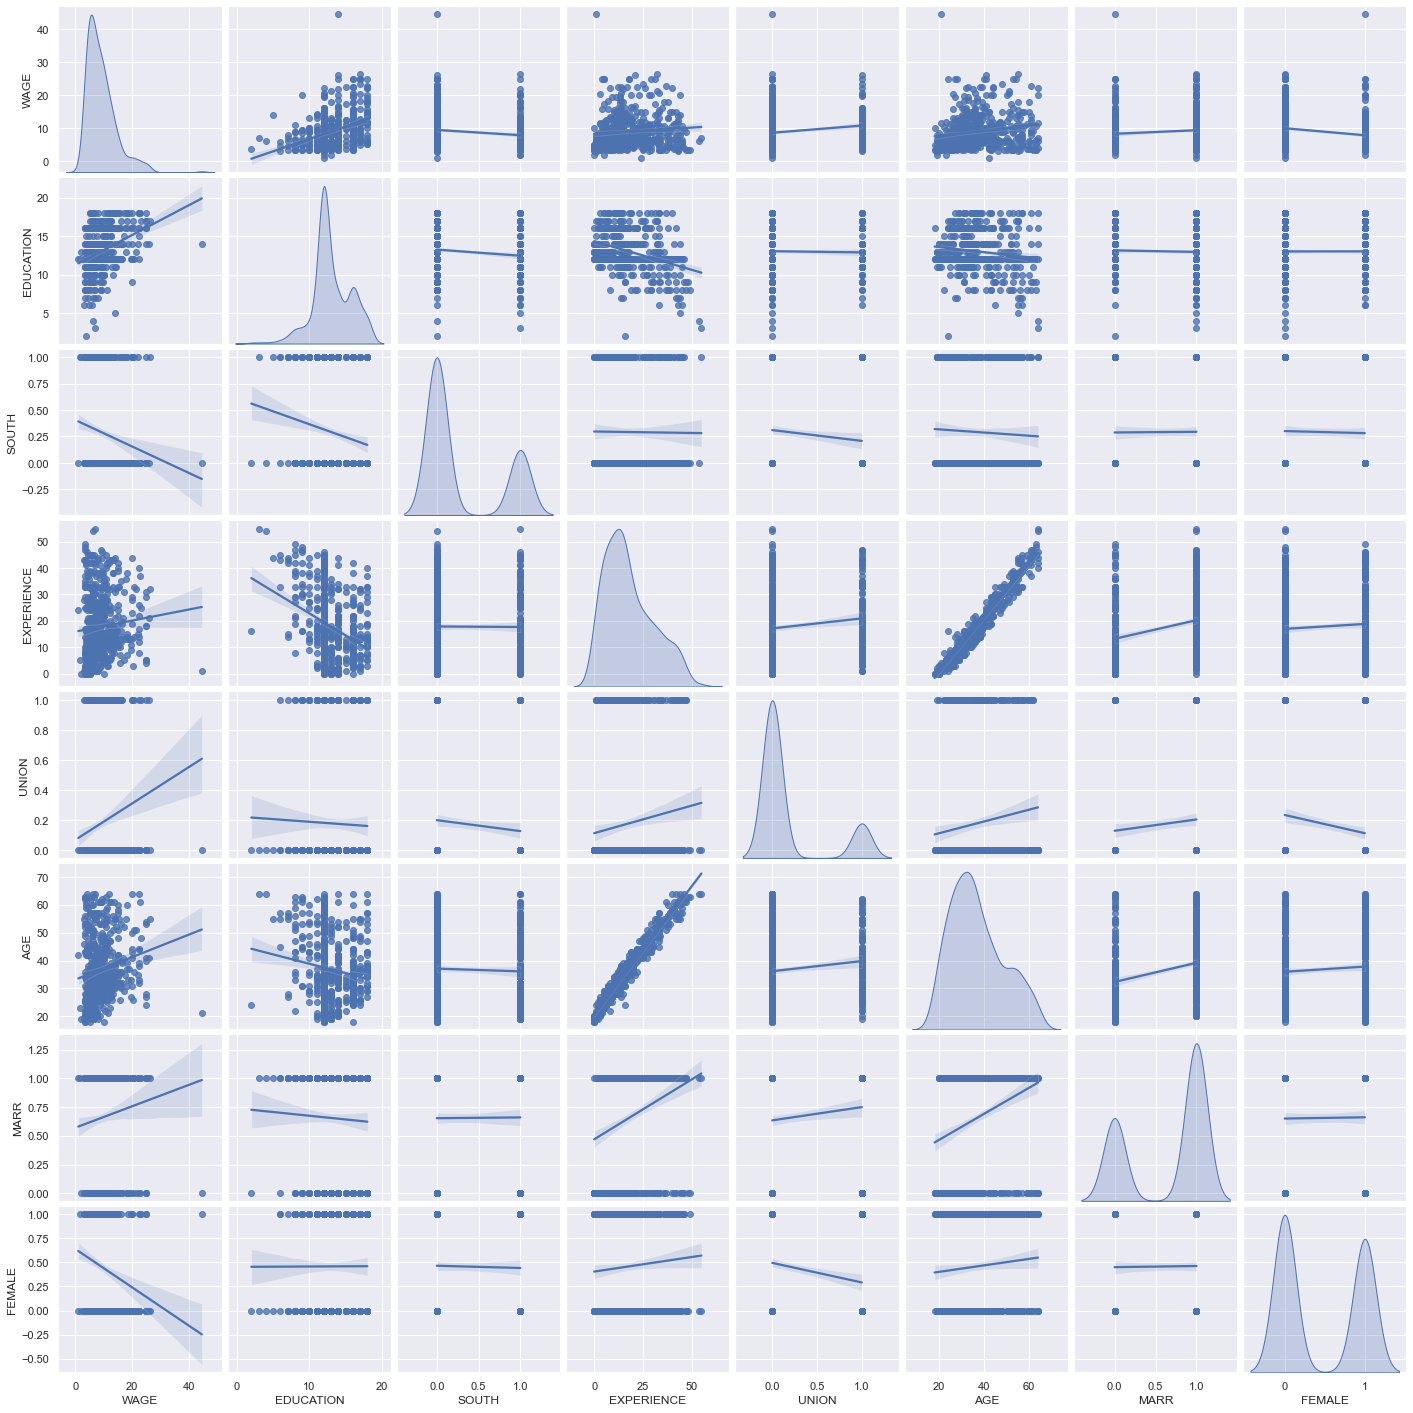

In [8]:
X_cpy = X.copy()
X_cpy.insert(0, "WAGE", y)

sns.pairplot(X_cpy, kind="reg", diag_kind="kde")
plt.show()

- Looking closely at the WAGE distribution reveals that it has a long tail. For this reason, we should take its logarithm to turn it approximately into a normal distribution (**linear models such as ridge or lasso work best for a normal distribution of error**).

- The WAGE is increasing when EDUCATION is increasing. Note that the dependence between WAGE and EDUCATION represented here is a marginal dependence, i.e., it describes the behavior of a specific variable without keeping the others fixed.

- Also, the EXPERIENCE and AGE are strongly linearly correlated.

In [9]:
X = pd.get_dummies(X, columns=['RACE', 'OCCUPATION', 'SECTOR'])
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EDUCATION                534 non-null    float64
 1   SOUTH                    534 non-null    int64  
 2   EXPERIENCE               534 non-null    float64
 3   UNION                    534 non-null    int64  
 4   AGE                      534 non-null    float64
 5   MARR                     534 non-null    int64  
 6   FEMALE                   534 non-null    int64  
 7   RACE_Hispanic            534 non-null    uint8  
 8   RACE_Other               534 non-null    uint8  
 9   RACE_White               534 non-null    uint8  
 10  OCCUPATION_Clerical      534 non-null    uint8  
 11  OCCUPATION_Management    534 non-null    uint8  
 12  OCCUPATION_Other         534 non-null    uint8  
 13  OCCUPATION_Professional  534 non-null    uint8  
 14  OCCUPATION_Sales         5

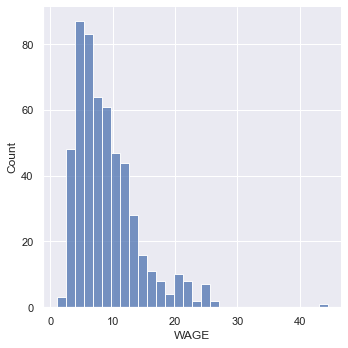

count    534.000000
mean       9.024064
std        5.139097
min        1.000000
25%        5.250000
50%        7.780000
75%       11.250000
max       44.500000
Name: WAGE, dtype: float64

In [10]:
sns.displot(y)
plt.show()

y.describe()

In [11]:
X.drop(y[y > 30].index, axis=0, inplace=True)
y.drop(y[y > 30].index, axis=0, inplace=True)
y.describe()

count    533.000000
mean       8.957505
std        4.908140
min        1.000000
25%        5.250000
50%        7.780000
75%       11.250000
max       26.290000
Name: WAGE, dtype: float64

In [12]:
# y_log = np.log10(y)
# y_log.describe()
y_log = y

**Split train and test**

>**Note:** if we want a validation set we need to split again the train set.

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_log, 
                                                    test_size=0.25, 
                                                    random_state=42)

## Linear Regression

In linear models, the target value is modeled as a **linear combination of the features**.

**Ridge**

In [124]:
from sklearn.metrics import median_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score
    
def evaluate(model, x, y, name='Train'):
    """
    Evaluate the predictions of a regressor.
    
    Args:
        model: (sklearn.model)
            The regressor.
        x: (array-like)
            Features.
        y: (array-like)
            Target output.
    """
    # Make predictions using the testing set
    y_pred = model.predict(x)
    
    # print info
    print(f'{name}:')
    print(f"\t- MAE: {median_absolute_error(y, y_pred):.5f}")
    print(f"\t- MAPE: {mean_absolute_percentage_error(y, y_pred):.5f}")
    print(f"\t- MSE: {mean_squared_error(y, y_pred):.5f}")
    print(f"\t- R2: {r2_score(y, y_pred):.5f}")
    
    return y_pred

In [125]:
from sklearn import linear_model

# Create linear regression object
model = linear_model.Ridge(alpha=1e-4)

# Train the model using the training sets
_ = model.fit(X_train, y_train)

# The coefficients
print("Coefficients: \n", model.coef_)

Coefficients: 
 [ 0.45711931 -0.21910875 -0.16866348  2.10066328  0.2884559   0.13806415
 -2.39600921 -0.43477193 -0.11217735  0.54694928 -0.68236676  2.23701673
 -0.60436535  1.64075532 -1.36103197 -1.23000798 -0.35110499  0.87480349
 -0.5236985 ]


In [126]:
# Train
evaluate(model, X_train, y_train, name='TRAIN')

# Test
y_pred = evaluate(model, X_test, y_test, name='TEST')

TRAIN:
	- MAE: 2.16688
	- MAPE: 0.39101
	- MSE: 14.63231
	- R2: 0.42100
TEST:
	- MAE: 2.77670
	- MAPE: 0.48431
	- MSE: 18.90361
	- R2: 0.06378


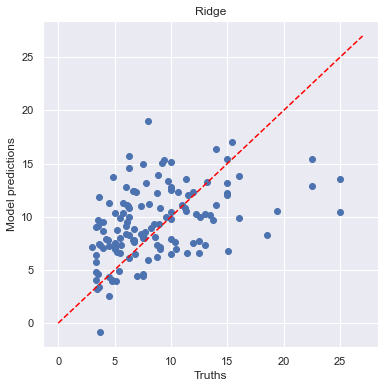

In [128]:
plt.figure(figsize=(6, 6))

#
plt.scatter(y_test, y_pred)
plt.plot([0, 27], [0, 27], ls="--", c="red")

plt.title("Ridge")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.show()

The model is far from being a good model making accurate predictions: this is obvious when looking at the plot above, where good predictions should lie on the red line.

### Interpreting coefficients:

#### Scaling matters

In [129]:
coefs = pd.DataFrame(model.coef_, columns=['Coefficients'], index=X.columns)
coefs

,Coefficients
EDUCATION,0.457119
SOUTH,-0.219109
EXPERIENCE,-0.168663
UNION,2.100663
AGE,0.288456
MARR,0.138064
FEMALE,-2.396009
RACE_Hispanic,-0.434772
RACE_Other,-0.112177
RACE_White,0.546949


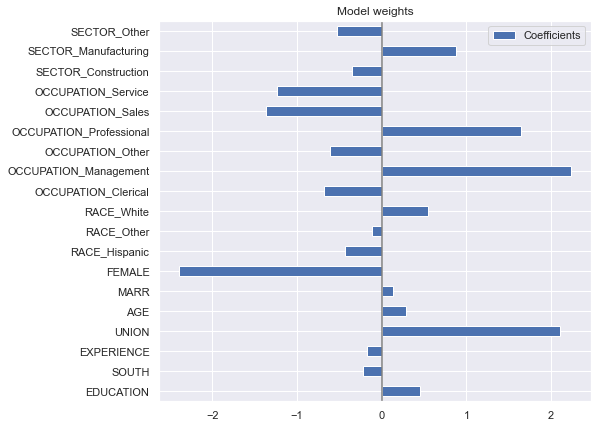

In [130]:
# Pandas shortcut for barh 
coefs.plot(kind="barh", figsize=(10, 7))
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

plt.title("Model weights")
plt.show()

From the above plot, the most important factor in determining WAGE appears to be the variable UNION, even if our intuition might tell us that variables like EXPERIENCE should have more impact.

Looking at the coefficient plot to gauge feature importance can be misleading as some of them vary on a small scale, while others, like AGE, varies a lot more, several decades.

In [131]:
X.describe()

,EDUCATION,SOUTH,EXPERIENCE,UNION,AGE,MARR,FEMALE,RACE_Hispanic,RACE_Other,RACE_White,OCCUPATION_Clerical,OCCUPATION_Management,OCCUPATION_Other,OCCUPATION_Professional,OCCUPATION_Sales,OCCUPATION_Service,SECTOR_Construction,SECTOR_Manufacturing,SECTOR_Other
count,533.000000,533.000000,533.000000,533.000000,533.000000,533.00000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000
mean,13.016886,0.292683,17.853659,0.180113,36.863039,0.65666,0.457786,0.050657,0.125704,0.823640,0.181989,0.101313,0.292683,0.196998,0.071295,0.155722,0.045028,0.185741,0.769231
std,2.617483,0.455422,12.369817,0.384642,11.717460,0.47527,0.498683,0.219502,0.331826,0.381484,0.386198,0.302027,0.455422,0.398105,0.257558,0.362933,0.207561,0.389263,0.421721
min,2.000000,0.000000,0.000000,0.000000,18.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,0.000000,8.000000,0.000000,28.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,12.000000,0.000000,15.000000,0.000000,35.000000,1.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,15.000000,1.000000,26.000000,0.000000,44.000000,1.00000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,18.000000,1.000000,55.000000,1.000000,64.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Solutions**:
1. Multiplying the coefficients by the standard deviation of the related feature would reduce all the coefficients to the same unit of measure. In that way, we emphasize that the greater the variance of a feature, the larger the weight of the corresponding coefficient on the output.

2. Another solution to the scaling problem of the coefficients is to scale **numerical values** before training the model. In this way we obtain already scaled coefficients.

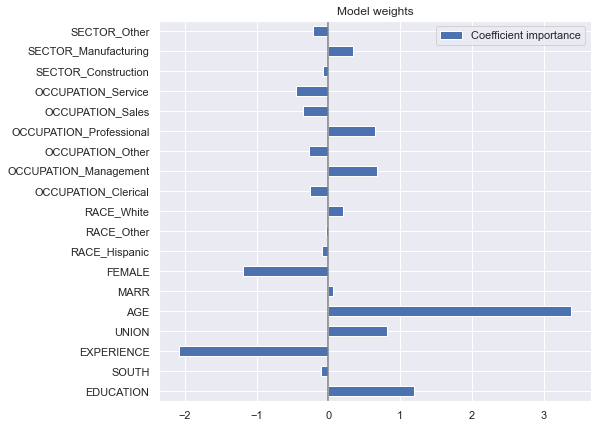

In [132]:
# 1. Multiply by the std
coefs = pd.DataFrame(
    model.coef_ * X.std(axis=0),
    columns=["Coefficient importance"],
    index=X.columns,
)

coefs.plot(kind="barh", figsize=(10, 7))
plt.title("Model weights")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [134]:
# 2. Scale numerical features
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X_train.iloc[:, :] = scaler.fit_transform(X_train.values)
X_test.iloc[:, :] = scaler.transform(X_test.values)

In [135]:
X_train.describe()

,EDUCATION,SOUTH,EXPERIENCE,UNION,AGE,MARR,FEMALE,RACE_Hispanic,RACE_Other,RACE_White,OCCUPATION_Clerical,OCCUPATION_Management,OCCUPATION_Other,OCCUPATION_Professional,OCCUPATION_Sales,OCCUPATION_Service,SECTOR_Construction,SECTOR_Manufacturing,SECTOR_Other
count,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02
mean,-2.448612e-16,9.571848e-17,-5.342427e-17,3.060765e-17,-1.202046e-16,-8.013640e-17,4.897224e-17,-8.236241e-17,2.226011e-17,4.452022e-18,1.335607e-17,3.339017e-18,1.335607e-17,1.023965e-16,5.119825e-17,2.671213e-17,-7.123235e-17,-4.452022e-17,2.671213e-17
std,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00
min,-3.899910e+00,-6.402296e-01,-1.458196e+00,-4.492296e-01,-1.632322e+00,-1.422226e+00,-9.534626e-01,-2.236068e-01,-3.828207e-01,-2.167948e+00,-4.968652e-01,-3.429972e-01,-6.246950e-01,-4.692371e-01,-2.952854e-01,-4.289245e-01,-2.236068e-01,-4.652563e-01,-1.852926e+00
25%,-3.794030e-01,-6.402296e-01,-8.230208e-01,-4.492296e-01,-7.881271e-01,-1.422226e+00,-9.534626e-01,-2.236068e-01,-3.828207e-01,4.612656e-01,-4.968652e-01,-3.429972e-01,-6.246950e-01,-4.692371e-01,-2.952854e-01,-4.289245e-01,-2.236068e-01,-4.652563e-01,5.396871e-01
50%,-3.794030e-01,-6.402296e-01,-1.878461e-01,-4.492296e-01,-1.127709e-01,7.031230e-01,-9.534626e-01,-2.236068e-01,-3.828207e-01,4.612656e-01,-4.968652e-01,-3.429972e-01,-6.246950e-01,-4.692371e-01,-2.952854e-01,-4.289245e-01,-2.236068e-01,-4.652563e-01,5.396871e-01
75%,4.029319e-01,1.561940e+00,6.855191e-01,-4.492296e-01,6.470047e-01,7.031230e-01,1.048809e+00,-2.236068e-01,-3.828207e-01,4.612656e-01,-4.968652e-01,-3.429972e-01,1.600781e+00,-4.692371e-01,-2.952854e-01,-4.289245e-01,-2.236068e-01,-4.652563e-01,5.396871e-01
max,1.967602e+00,1.561940e+00,2.908630e+00,2.226033e+00,2.250976e+00,7.031230e-01,1.048809e+00,4.472136e+00,2.612189e+00,4.612656e-01,2.012618e+00,2.915476e+00,1.600781e+00,2.131119e+00,3.386554e+00,2.331412e+00,4.472136e+00,2.149353e+00,5.396871e-01


In [137]:
# Fit a new model
model = linear_model.Ridge(alpha=1e-4)
_ = model.fit(X_train, y_train)
#
_ = evaluate(model, X_test, y_test, name='TEST')

TEST:
	- MAE: 2.77670
	- MAPE: 0.48368
	- MSE: 18.88309
	- R2: 0.06480


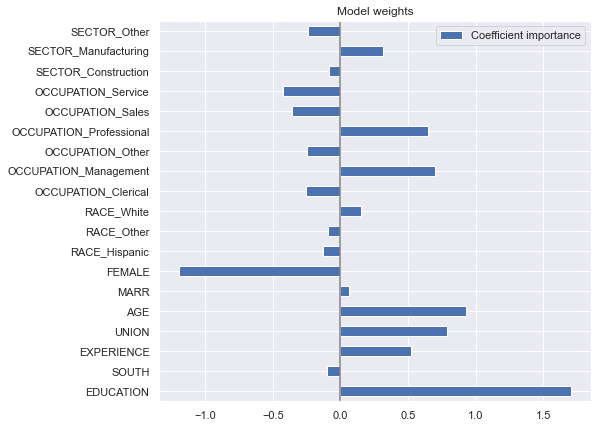

In [138]:
coefs = pd.DataFrame(
    model.coef_, 
    columns=['Coefficient importance'], 
    index=X_train.columns
)
coefs.plot(kind="barh", figsize=(10, 7))
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

plt.title("Model weights")
plt.show()

#### Robustness

If coefficients vary significantly when changing the input dataset their robustness is not guaranteed, and they should probably be interpreted with caution.

We can check the coefficient variability through [**cross-validation**](https://scikit-learn.org/stable/modules/cross_validation.html).

In [139]:
X_train.describe()

,EDUCATION,SOUTH,EXPERIENCE,UNION,AGE,MARR,FEMALE,RACE_Hispanic,RACE_Other,RACE_White,OCCUPATION_Clerical,OCCUPATION_Management,OCCUPATION_Other,OCCUPATION_Professional,OCCUPATION_Sales,OCCUPATION_Service,SECTOR_Construction,SECTOR_Manufacturing,SECTOR_Other
count,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02,3.990000e+02
mean,-2.448612e-16,9.571848e-17,-5.342427e-17,3.060765e-17,-1.202046e-16,-8.013640e-17,4.897224e-17,-8.236241e-17,2.226011e-17,4.452022e-18,1.335607e-17,3.339017e-18,1.335607e-17,1.023965e-16,5.119825e-17,2.671213e-17,-7.123235e-17,-4.452022e-17,2.671213e-17
std,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00,1.001255e+00
min,-3.899910e+00,-6.402296e-01,-1.458196e+00,-4.492296e-01,-1.632322e+00,-1.422226e+00,-9.534626e-01,-2.236068e-01,-3.828207e-01,-2.167948e+00,-4.968652e-01,-3.429972e-01,-6.246950e-01,-4.692371e-01,-2.952854e-01,-4.289245e-01,-2.236068e-01,-4.652563e-01,-1.852926e+00
25%,-3.794030e-01,-6.402296e-01,-8.230208e-01,-4.492296e-01,-7.881271e-01,-1.422226e+00,-9.534626e-01,-2.236068e-01,-3.828207e-01,4.612656e-01,-4.968652e-01,-3.429972e-01,-6.246950e-01,-4.692371e-01,-2.952854e-01,-4.289245e-01,-2.236068e-01,-4.652563e-01,5.396871e-01
50%,-3.794030e-01,-6.402296e-01,-1.878461e-01,-4.492296e-01,-1.127709e-01,7.031230e-01,-9.534626e-01,-2.236068e-01,-3.828207e-01,4.612656e-01,-4.968652e-01,-3.429972e-01,-6.246950e-01,-4.692371e-01,-2.952854e-01,-4.289245e-01,-2.236068e-01,-4.652563e-01,5.396871e-01
75%,4.029319e-01,1.561940e+00,6.855191e-01,-4.492296e-01,6.470047e-01,7.031230e-01,1.048809e+00,-2.236068e-01,-3.828207e-01,4.612656e-01,-4.968652e-01,-3.429972e-01,1.600781e+00,-4.692371e-01,-2.952854e-01,-4.289245e-01,-2.236068e-01,-4.652563e-01,5.396871e-01
max,1.967602e+00,1.561940e+00,2.908630e+00,2.226033e+00,2.250976e+00,7.031230e-01,1.048809e+00,4.472136e+00,2.612189e+00,4.612656e-01,2.012618e+00,2.915476e+00,1.600781e+00,2.131119e+00,3.386554e+00,2.331412e+00,4.472136e+00,2.149353e+00,5.396871e-01


In [140]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
#print(help(cross_validate))

model = linear_model.Ridge(alpha=1e-9)
cv_model = cross_validate(
    model,
    X_train,
    y_train,
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=42),
    return_estimator=True,
)

In [141]:
coefs = pd.DataFrame(
    [est.coef_ for est in cv_model["estimator"]],
    columns=X.columns,
)
coefs

,EDUCATION,SOUTH,EXPERIENCE,UNION,AGE,MARR,FEMALE,RACE_Hispanic,RACE_Other,RACE_White,OCCUPATION_Clerical,OCCUPATION_Management,OCCUPATION_Other,OCCUPATION_Professional,OCCUPATION_Sales,OCCUPATION_Service,SECTOR_Construction,SECTOR_Manufacturing,SECTOR_Other
0,1.661641,-0.151413,0.532990,0.463660,0.925877,0.233897,-1.220640,-0.212871,0.019074,0.102616,-0.291244,0.908184,-0.412414,0.698970,-0.332878,-0.431158,-0.014720,0.313177,-0.278689
1,1.675498,-0.117414,0.442661,1.035869,0.832513,0.074194,-1.116426,-0.097330,-0.188733,0.220172,-0.256798,0.659673,-0.177779,0.529056,-0.386908,-0.326552,-0.275556,0.315900,-0.149015
2,1.722173,0.007277,0.490730,0.902117,0.893323,-0.082000,-1.121404,-0.157778,-0.117657,0.191534,-0.228934,0.592527,-0.245654,0.643715,-0.365732,-0.356233,-0.033420,0.395542,-0.345307
3,1.711335,-0.147645,0.605851,0.751744,1.013515,0.049773,-1.315380,-0.092271,-0.076041,0.118224,-0.215597,0.760564,-0.241289,0.676282,-0.382645,-0.539189,-0.035162,0.226573,-0.189410
4,1.715999,-0.085452,0.537299,0.787336,0.941451,0.010575,-1.201903,-0.065681,-0.097222,0.121992,-0.276258,0.625409,-0.180515,0.704602,-0.321427,-0.508826,-0.128192,0.321197,-0.228243
5,1.584963,-0.210353,0.587144,0.914980,0.966532,-0.167422,-1.201688,-0.308294,-0.046378,0.213520,-0.209002,0.539243,-0.216717,0.790003,-0.351278,-0.533726,-0.099591,0.286098,-0.211258
6,1.709907,-0.048311,0.468743,0.985873,0.867333,0.098578,-1.049269,-0.045949,-0.096155,0.110215,-0.188241,0.736868,-0.161958,0.565461,-0.385153,-0.528253,-0.201589,0.346707,-0.214667
7,1.596139,-0.213036,0.613236,0.619523,0.996211,0.169705,-1.344362,-0.063983,-0.087926,0.113188,-0.316217,0.684401,-0.363135,0.758861,-0.287924,-0.371858,-0.045653,0.372127,-0.317896
8,1.779417,-0.013787,0.423633,0.775402,0.834284,0.126158,-1.195019,-0.072296,-0.140056,0.163412,-0.243154,0.755592,-0.322097,0.664529,-0.364263,-0.405047,0.033313,0.258699,-0.254337
9,1.890139,-0.016722,0.536247,0.648615,0.977762,0.074420,-1.197431,-0.151086,-0.063754,0.140659,-0.328282,0.801708,-0.169133,0.450322,-0.397167,-0.289106,-0.128270,0.282109,-0.193091


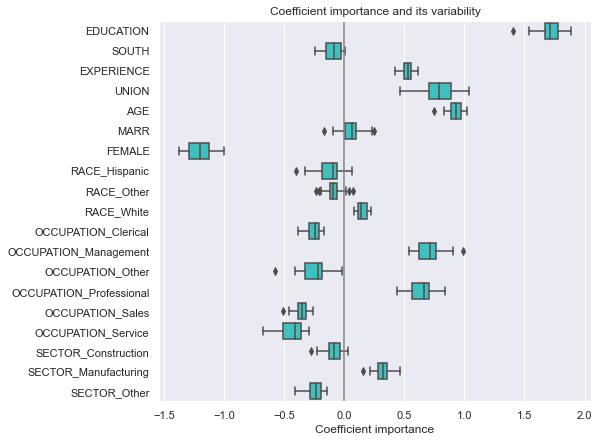

In [142]:
plt.figure(figsize=(10, 7))

#sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")

plt.title("Coefficient importance and its variability")
plt.subplots_adjust(left=0.3)

#### Co-linearity
The AGE and EXPERIENCE coefficients are affected by strong variability which might be due to the collinearity between the 2 features: as AGE and EXPERIENCE vary together in the data, their effect is difficult to tease apart (**noise can cause problems**). 

To verify this interpretation we remove one of the 2 features and check what is the impact on the model stability.

In [143]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
#print(help(cross_validate))

model = linear_model.Ridge(alpha=1e-9)
cv_model = cross_validate(
    model,
    X_train.drop(["AGE"], axis=1),
    y_train,
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=42),
    return_estimator=True
)

In [144]:
coefs = pd.DataFrame(
    [est.coef_ for est in cv_model["estimator"]],
    columns=X.drop(["AGE"], axis=1).columns,
)
coefs

,EDUCATION,SOUTH,EXPERIENCE,UNION,MARR,FEMALE,RACE_Hispanic,RACE_Other,RACE_White,OCCUPATION_Clerical,OCCUPATION_Management,OCCUPATION_Other,OCCUPATION_Professional,OCCUPATION_Sales,OCCUPATION_Service,SECTOR_Construction,SECTOR_Manufacturing,SECTOR_Other
0,1.861459,-0.151413,1.517439,0.463660,0.233897,-1.220640,-0.212880,0.019060,0.102599,-0.291231,0.908194,-0.412399,0.698983,-0.332869,-0.431146,-0.014751,0.313120,-0.278751
1,1.855166,-0.117414,1.327839,1.035869,0.074194,-1.116426,-0.097334,-0.188741,0.220164,-0.256817,0.659659,-0.177800,0.529038,-0.386921,-0.326569,-0.275556,0.315900,-0.149015
2,1.914965,0.007277,1.440565,0.902117,-0.082000,-1.121404,-0.157773,-0.117649,0.191543,-0.228949,0.592515,-0.245670,0.643701,-0.365742,-0.356246,-0.033426,0.395530,-0.345321
3,1.930066,-0.147645,1.683481,0.751744,0.049773,-1.315380,-0.092260,-0.076024,0.118244,-0.215568,0.760586,-0.241256,0.676310,-0.382626,-0.539162,-0.035165,0.226568,-0.189415
4,1.919178,-0.085452,1.538307,0.787336,0.010575,-1.201903,-0.065671,-0.097206,0.122011,-0.276235,0.625427,-0.180489,0.704625,-0.321411,-0.508805,-0.128192,0.321198,-0.228241
5,1.793555,-0.210353,1.614819,0.914980,-0.167422,-1.201688,-0.308284,-0.046363,0.213537,-0.208979,0.539260,-0.216691,0.790025,-0.351263,-0.533706,-0.099619,0.286047,-0.211314
6,1.897090,-0.048311,1.390944,0.985873,0.098578,-1.049269,-0.045942,-0.096144,0.110227,-0.188248,0.736862,-0.161966,0.565454,-0.385158,-0.528260,-0.201579,0.346725,-0.214648
7,1.811136,-0.213036,1.672468,0.619523,0.169705,-1.344362,-0.063987,-0.087932,0.113181,-0.316225,0.684395,-0.363145,0.758853,-0.287930,-0.371866,-0.045713,0.372018,-0.318014
8,1.959468,-0.013787,1.310694,0.775402,0.126158,-1.195019,-0.072286,-0.140040,0.163431,-0.243133,0.755608,-0.322073,0.664549,-0.364248,-0.405028,0.033296,0.258668,-0.254371
9,2.101154,-0.016722,1.575862,0.648615,0.074420,-1.197431,-0.151092,-0.063764,0.140648,-0.328312,0.801685,-0.169166,0.450294,-0.397187,-0.289133,-0.128270,0.282107,-0.193093


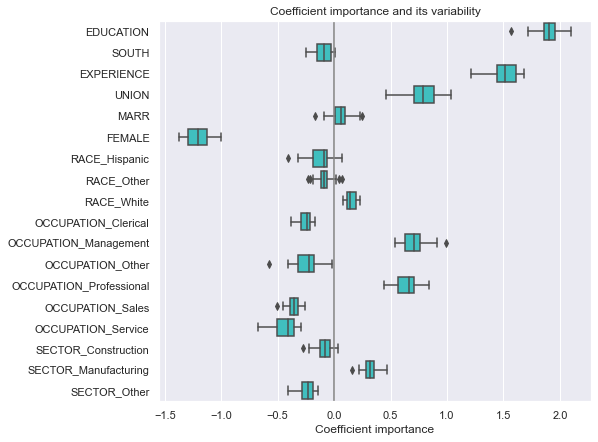

In [145]:
plt.figure(figsize=(10, 7))

#sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")

plt.title("Coefficient importance and its variability")
plt.subplots_adjust(left=0.3)

#### Alpha hyperparameter

This example shows the usefulness of applying Ridge regression to highly ill-conditioned matrices. For such matrices, a slight change in the target variable can cause huge variances in the calculated weights. In such cases, it is useful to set a certain regularization (alpha) to reduce this variation (noise).

When alpha is very large, the regularization effect dominates the squared loss function and the coefficients tend to zero. At the end of the path, as alpha tends toward zero and the solution tends towards the ordinary least squares, coefficients exhibit big oscillations. In practise it is necessary to tune alpha in such a way that a balance is maintained between both.

In [29]:
# X is the 10x10 Hilbert matrix
X_hilbert = 1.0 / (np.arange(1, 11) + np.arange(0, 10)[:, np.newaxis])
y_hilbert = np.ones(10)

In [30]:
# The features (10 rows, 10 features)
X_hilbert

array([[1.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
        0.16666667, 0.14285714, 0.125     , 0.11111111, 0.1       ],
       [0.5       , 0.33333333, 0.25      , 0.2       , 0.16666667,
        0.14285714, 0.125     , 0.11111111, 0.1       , 0.09090909],
       [0.33333333, 0.25      , 0.2       , 0.16666667, 0.14285714,
        0.125     , 0.11111111, 0.1       , 0.09090909, 0.08333333],
       [0.25      , 0.2       , 0.16666667, 0.14285714, 0.125     ,
        0.11111111, 0.1       , 0.09090909, 0.08333333, 0.07692308],
       [0.2       , 0.16666667, 0.14285714, 0.125     , 0.11111111,
        0.1       , 0.09090909, 0.08333333, 0.07692308, 0.07142857],
       [0.16666667, 0.14285714, 0.125     , 0.11111111, 0.1       ,
        0.09090909, 0.08333333, 0.07692308, 0.07142857, 0.06666667],
       [0.14285714, 0.125     , 0.11111111, 0.1       , 0.09090909,
        0.08333333, 0.07692308, 0.07142857, 0.06666667, 0.0625    ],
       [0.125     , 0.11111111, 0.1      

In [31]:
n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)

coefs = []
for a in alphas:
    # We just leave aside the intercept in this example
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_hilbert, y_hilbert)
    coefs.append(ridge.coef_)

Each color represents a different feature of the coefficient vector, and this is displayed as a function of the regularization parameter.

> **Note** that when alpha is $10^{-9}$ Ridge becomes very like OLS.

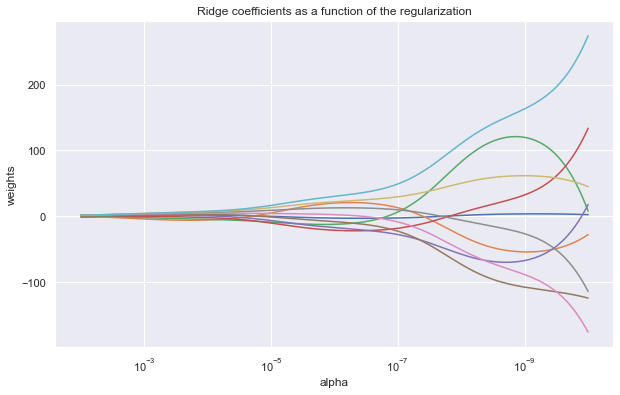

In [32]:
plt.figure(figsize=(10, 6))

plt.plot(alphas, coefs)

plt.xscale("log")
plt.xlim(plt.xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.show()

### OLS vs Ridge

How does the regularization affect linear regression?

In [69]:
from sklearn import linear_model

# A dataset of only two points
Xx_train = np.c_[0.5, 1].T
yy_train = [0.5, 1]
Xx_test = np.c_[0, 2].T

**Ordinary Least Squares**:

- Due to the few points in each dimension, the noise on the observations (points) causes great variance in the straight line that OLS uses to follow these points. Every line’s slope can vary quite a lot for each prediction due to the noise induced in the observations:

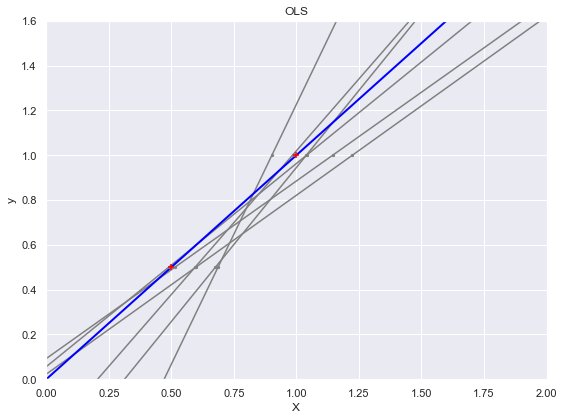

In [70]:
np.random.seed(0)
ols = linear_model.LinearRegression()

plt.figure(figsize=(8, 6))

# Add noise to the observations
for _ in range(6):
    noise = 0.1 * np.random.normal(size=(2, 1))
    this_X = noise + Xx_train
    ols.fit(this_X, yy_train)

    plt.plot(Xx_test, ols.predict(Xx_test), color="gray")
    plt.scatter(this_X, yy_train, s=5, c="gray", marker="o", zorder=10)

ols.fit(Xx_train, yy_train)

plt.plot(Xx_test, ols.predict(Xx_test), linewidth=2, color="blue")
plt.scatter(Xx_train, yy_train, s=30, c="red", marker="+", zorder=10)

plt.title('OLS')
plt.xlim(0, 2)
plt.ylim((0, 1.6))
plt.xlabel("X")
plt.ylabel("y")
plt.tight_layout()
plt.show()

**Ridge**

- Ridge regression minimizes a penalized version of the least-squared function where the penalty shrinks the value of the regression coefficients. Despite the few data points in each dimension, the slope of the prediction is much **more stable** and the variance in the line is greatly reduced:

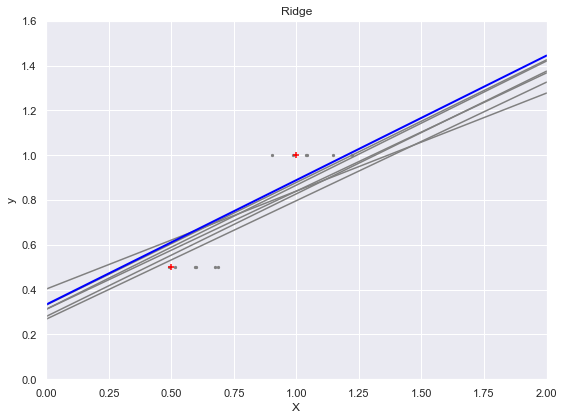

In [71]:
np.random.seed(0)
ridge = linear_model.Ridge(alpha=0.1)

plt.figure(figsize=(8, 6))

# Add noise to the observations
for _ in range(6):
    noise = 0.1 * np.random.normal(size=(2, 1))
    this_X = noise + Xx_train
    ridge.fit(this_X, yy_train)

    plt.plot(Xx_test, ridge.predict(Xx_test), color="gray")
    plt.scatter(this_X, yy_train, s=5, c="gray", marker="o", zorder=10)

ridge.fit(Xx_train, yy_train)

plt.plot(Xx_test, ridge.predict(Xx_test), linewidth=2, color="blue")
plt.scatter(Xx_train, yy_train, s=30, c="red", marker="+", zorder=10)

plt.title('Ridge')
plt.xlim(0, 2)
plt.ylim((0, 1.6))
plt.xlabel("X")
plt.ylabel("y")
plt.tight_layout()
plt.show()

----
## Decision tree

Let's just import again the dataset and make the minimal preprocessing (transforming categorical features with one-hot and log scale the labels).

In [149]:
from sklearn.datasets import fetch_openml

survey = fetch_openml(data_id=534, as_frame=True)
X = survey.data.copy()
y = survey.target.copy()

# Convert SOUTH, FEMALE, and MARR to bool 
X.loc[:, 'SOUTH'] = X.SOUTH.str.replace('no', '0').replace('yes', '1').astype(int)
X.loc[:, 'MARR'] = X.MARR.str.replace('Unmarried', '0').replace('Married', '1').astype(int)
X.loc[:, 'UNION'] = X.UNION.str.replace('not_member', '0').replace('member', '1').astype(int)

X['FEMALE'] = X.SEX.str.replace('female', '1').replace('male', '0').astype(int)
X.drop('SEX', axis=1, inplace=True)

X.drop(y[y > 30].index, axis=0, inplace=True)
y.drop(y[y > 30].index, axis=0, inplace=True)

X = pd.get_dummies(X, columns=['RACE', 'OCCUPATION', 'SECTOR'])
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533 entries, 0 to 533
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EDUCATION                533 non-null    float64
 1   SOUTH                    533 non-null    int64  
 2   EXPERIENCE               533 non-null    float64
 3   UNION                    533 non-null    int64  
 4   AGE                      533 non-null    float64
 5   MARR                     533 non-null    int64  
 6   FEMALE                   533 non-null    int64  
 7   RACE_Hispanic            533 non-null    uint8  
 8   RACE_Other               533 non-null    uint8  
 9   RACE_White               533 non-null    uint8  
 10  OCCUPATION_Clerical      533 non-null    uint8  
 11  OCCUPATION_Management    533 non-null    uint8  
 12  OCCUPATION_Other         533 non-null    uint8  
 13  OCCUPATION_Professional  533 non-null    uint8  
 14  OCCUPATION_Sales         5

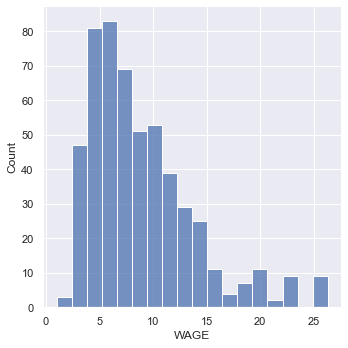

In [151]:
sns.displot(y)
plt.show()

In [152]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.25, 
                                                    random_state=42)

At this point we want to compare the performance of a Decision Tree with the Linear Regression of the previous section.

In [155]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import median_absolute_error, mean_squared_error

# Create linear regression object
model = DecisionTreeRegressor(max_depth=5, 
                              min_samples_leaf=5,
                              max_features='sqrt')

# Train the model using the training sets
_ = model.fit(X_train, y_train)

In [156]:
#
evaluate(model, X_train, y_train, name='TRAIN')

#
y_pred = evaluate(model, X_test, y_test, name='TRAIN')

TRAIN:
	- MAE: 1.90391
	- MAPE: 0.33759
	- MSE: 14.50297
	- R2: 0.48457
TRAIN:
	- MAE: 2.72111
	- MAPE: 0.51358
	- MSE: 22.08641
	- R2: 0.02479


From the train and test metrics, we can see that we are not in overfitting regime.

> I just try some value for the **hyperparameters**, can you do better than me?

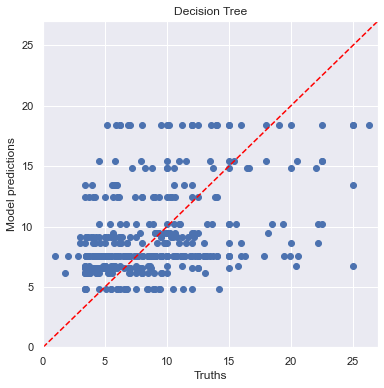

In [158]:
plt.figure(figsize=(6, 6))

plt.scatter(y_test, y_pred)
plt.plot([0, 27], [0, 27], ls="--", c="red")

plt.title("Decision Tree")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([0, 27])
plt.ylim([0, 27])
plt.show()

From the plot of the residuals, it seems that the Decision Tree has the same performance of the Linear Regression.

### Ex: Hyper-parameter Optimization
 Optimize the most important hyper-parameters of the decision tree.

### Feature importance

The importance of a feature is computed as the (normalized) total reduction of the criterion (Variation Reduction) brought by that feature. It is also known as the **Gini importance**.

> **Note**: impurity-based feature importances can be misleading for high cardinality features (many unique values). When there are many categorical features it is better to use permutation importance.

In [159]:
coefs = pd.DataFrame(model.feature_importances_, 
                     columns=['Feature importance'], index=X.columns)
coefs

,Feature importance
EDUCATION,0.597594
SOUTH,0.000000
EXPERIENCE,0.067789
UNION,0.000000
AGE,0.284943
MARR,0.026536
FEMALE,0.017505
RACE_Hispanic,0.000000
RACE_Other,0.000000
RACE_White,0.000000


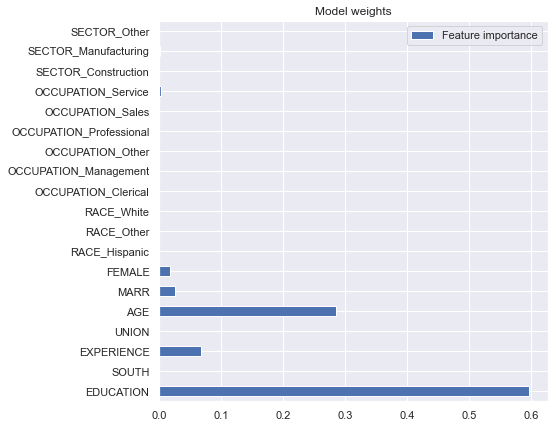

In [160]:
# Pandas shortcut for barh 
coefs.plot(kind="barh", figsize=(9, 7))
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

plt.title("Model weights")
plt.show()

We can easily plot a tree with:

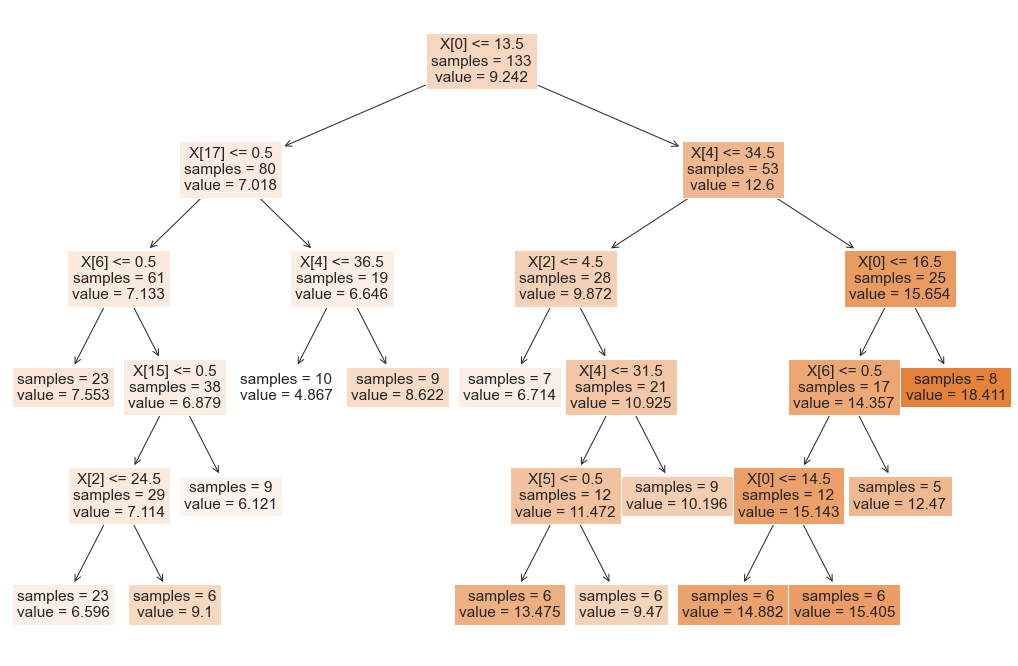

In [161]:
from sklearn.tree import plot_tree

plt.figure(figsize=(18, 12))
plot_tree(model, filled=True, impurity=False)
plt.show()

### Overfitting

Overfitting is the use of models that **violate Occam's razor**, for example by including more adjustable parameters than are ultimately optimal, or by using a more complicated approach than is ultimately optimal. 

In Decision tree, overfitting may be limited by carefully tuning the hperparameters such as the max_depth and min_samples_split (minimum number of samples to split a branching node).

In [162]:
# Create a random dataset by sampling observation from sin and adding a random noise 
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

In [163]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

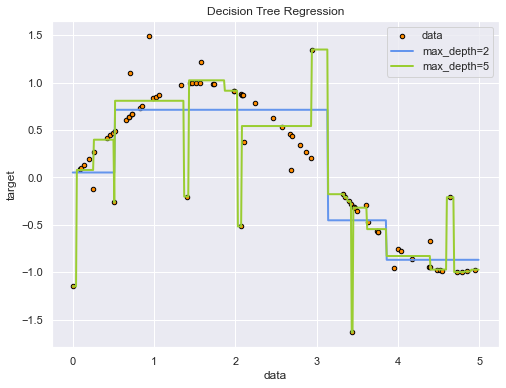

In [164]:
# Plot the results
plt.figure(figsize=(8, 6))

plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)

plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

As we can see, limiting the depth of a tree is a way to prevent overfitting!

> **Note**: tuning the hyperparameters of a Decision Tree means to find the right trade-off between performance and overfitting. For instance, in the above example, reducing the depth of the tree prevents overfitting, but at the same time worsen the function approaximation.